In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import expon, geom
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from utils import despine_ax
from loaders import SpikeRecording
plt.style.use('pcb')

0.10497318878419216
0.24961374794266494


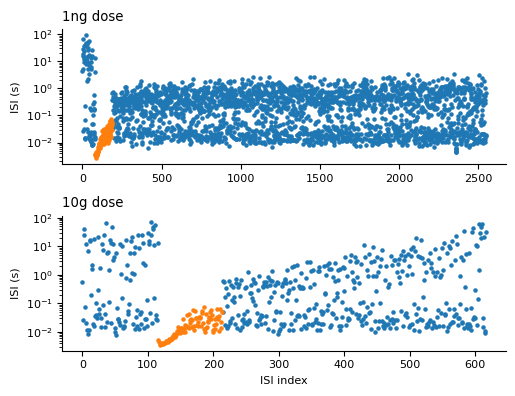

In [2]:
def plot_rebound(ix, ax):
    start = 905

    spiketrain = pd.read_csv(tgstn_files[ix], sep='\t')['spike times'].values
    spiketrain = spiketrain[(spiketrain < 1800)]

    spikerec = SpikeRecording(spiketrain, 0, 1800)
    print(spikerec.threshold())

    spiketrain = spikerec.spiketrain

    isis = np.diff(spiketrain)
    xx = np.arange(len(isis))

    mask_response = (spiketrain[:-1] > 900) & (spiketrain[:-1] < 902)

    ax.scatter(xx[~mask_response], isis[~mask_response], s=5)
    ax.scatter(xx[mask_response], isis[mask_response], s=5)
    ax.set_yscale('log')
    ax.set_ylabel('ISI (s)')
    ax.set_xlabel('ISI index')

fig, axes = plt.subplots(figsize=(5.2,4), nrows=2)

plot_rebound(9, axes[0])
axes[0].set_xlabel('')
plot_rebound(2, axes[1])

axes[0].set_title('1ng dose', loc='left')
axes[1].set_title('10g dose', loc='left')

plt.tight_layout()
plt.savefig('img/rebound.png')

In [3]:
def func(x, a1, b1, a2, b2, c):
    return a1*np.exp(-x/b1)+a2*np.exp(-x/b2)+c

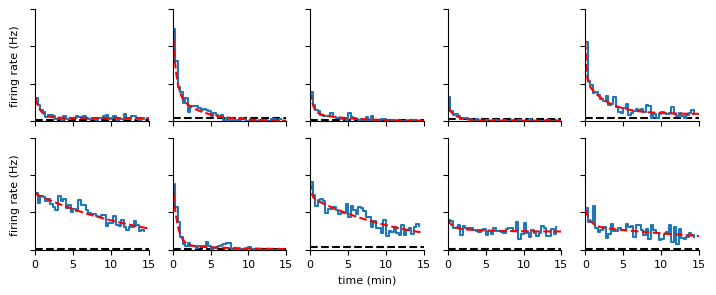

In [69]:
def plot_rebound(axes):
    start = 905
    # 4, 10
    ix = 11

    ixs = [0,1,2,3,5,6,7,8,9,11]

    params = []
    fitted_names = ['a1','b1','a2','b2','c']

    for ix, ax in zip(ixs, axes.flat):
        params.append({})
        spiketrain = pd.read_csv(tgstn_files[ix], sep='\t')['spike times'].values
        spiketrain = spiketrain[(spiketrain < 1800)]
        spont = (spiketrain < 900).sum() / 900
        spiketrain = spiketrain - start

        bin_width = 20
        bins = np.arange(0, 900, bin_width)

        # plt.hist(spiketrain, bins=bins)
        ax.axhline(spont, color='black', linestyle='dashed')

        counts, bins = np.histogram(spiketrain, bins)
        counts = counts / bin_width

        bounds = np.array([(0, np.inf), (1e-3, np.inf), (0, np.inf), (1e-3, np.inf), (0, np.inf)]).T
        x = bins[:-1]
        popt, pcov = curve_fit(func, x, counts, p0=(2, 40, 2, 200, 1), bounds=bounds)

        for key, p in zip(fitted_names, popt):
            params[-1][key] = p

        params[-1]['spont'] = spont

        ax.step(bins[:-1], counts, where='post')

        xx = np.linspace(0,900, 10000)
        ax.plot(xx, func(xx, *popt), linestyle='dashed', color='red', label=r'$a_1\exp(-t/\tau_1)+a_2\exp(-t/\tau_2)+c$')
        ax.set_ylim(0,15)
        ax.set_xlim(0,15*60)

    axes[0,0].set_ylabel('firing rate (Hz)')
    axes[1,0].set_ylabel('firing rate (Hz)')
    axes[1,2].set_xlabel('time (min)')

    xticks = [0, 300, 600, 900]
    for ax in axes.flat:
        ax.set_xticks(xticks)
        ax.set_xticklabels([])
    
    for ax in axes[1,:]:
        ax.set_xticklabels([f'{xt / 60:.0f}' for xt in xticks])
        
    for ax in axes[:,1:].flat:
        ax.set_yticklabels([])
        
    return pd.DataFrame(params)
    

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(7.2,3), sharex=True, sharey=True)

params = plot_rebound(axes)

plt.tight_layout()
# plt.savefig('img/rebound.png')

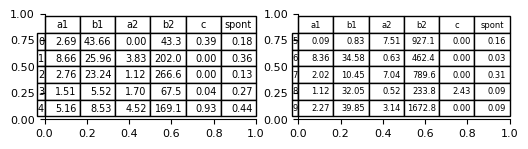

In [61]:
fig, axes = plt.subplots(ncols=2, figsize=(6,1.4))

df = params.copy()

for col in ['a1','b1','a2','c','spont']:
    df[col] = df[col].map(lambda x: f'{x:.2f}')

df['b2'] = df['b2'].map(lambda x: f'{x:.1f}')

df1 = df.iloc[:5]
df2 = df.iloc[5:]

pd.plotting.table(axes[0], df1, loc='center')
pd.plotting.table(axes[1], df2, loc='center')

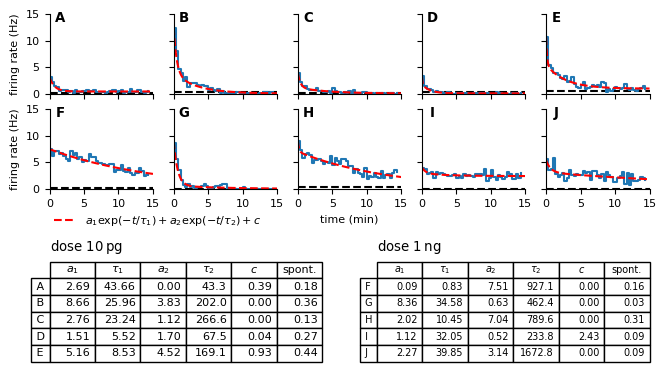

In [85]:
fig = plt.figure(figsize=(6, 3.5))

gs_plots = fig.add_gridspec(2,5, top=1, bottom=0.5, left=0, right=1)

axes = np.empty((2,5), dtype=object)

for row in range(2):
    for col in range(5):
        axes[row, col] = fig.add_subplot(gs_plots[row, col])
        
        
params = plot_rebound(axes)
letters = ['A','B','C','D','E','F','G','H','I','J']

for ax, l in zip(axes.flat, letters):
    ax.set_title(l, x=0.1, y=0.8, fontweight='bold')

axes[1,0].legend(loc=(0,-0.55), frameon=False)

gs_tables = fig.add_gridspec(1,2, top=0.3, bottom=0., left=0, right=1)

axes = [fig.add_subplot(gs_tables[i]) for i in range(2)]

df = params.copy()

for col in ['a1','b1','a2','c','spont']:
    df[col] = df[col].map(lambda x: f'{x:.2f}')

df['b2'] = df['b2'].map(lambda x: f'{x:.1f}')

df.columns = [r'$a_1$', r'$\tau_1$', r'$a_2$', r'$\tau_2$', r'$c$', 'spont.']
df.index = [f' {l} ' for l in letters]

df1 = df.iloc[:5]
df2 = df.iloc[5:]

pd.plotting.table(axes[0], df1, loc='center')
pd.plotting.table(axes[1], df2, loc='center')

for ax in axes:
    despine_ax(ax)
    
axes[0].set_title(r'dose 10$\,$pg', loc='left')
axes[1].set_title(r'dose 1$\,$ng', loc='left')

plt.savefig('img/rebound_with_tables.png')

In [33]:
np.empty((5,2))

array([[0.01 , 0.02 ],
       [0.025, 0.05 ],
       [0.1  , 0.2  ],
       [0.25 , 0.5  ],
       [1.   , 2.   ]])

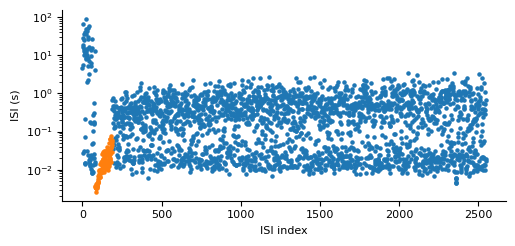

In [38]:
fig, ax = plt.subplots(figsize=(5.2,2.5))



plt.tight_layout()
plt.savefig('img/rebound.png')

In [5]:
isis

array([9.100000e-03, 7.878200e+00, 1.350000e-02, 2.170000e-02,
       9.200000e-03, 9.900000e-03, 7.740000e-02, 3.327000e-01,
       8.500000e-03, 1.468000e-01, 2.315000e-01, 8.560000e-02,
       1.356700e+00, 4.900000e-03, 5.300000e-03, 9.200000e-03,
       5.300000e-03, 9.200000e-03, 7.600000e-03, 5.510000e-02,
       1.080000e-02, 1.490000e-02, 4.890000e-01, 7.700000e-03,
       9.366600e+00, 2.390000e-02, 2.550000e-02, 2.280000e-02,
       2.901000e+00, 7.650000e-01, 5.510000e-02, 2.180000e-02,
       7.697000e-01, 1.060000e-02, 7.803000e-01, 2.936670e+01,
       1.230000e-02, 3.190000e-02, 1.220000e-02, 1.180000e-02,
       5.441900e+00, 1.840000e-02, 4.510000e-02, 3.201300e+00,
       3.070000e-02, 1.580000e-02, 7.120000e-02, 8.158000e-01,
       6.000000e-03, 6.200000e-03, 6.400000e-03, 6.100000e-03,
       2.320000e-02, 1.087500e+00, 1.090000e-02, 1.310000e-02,
       2.660000e-02, 3.290000e-02, 8.569700e+00, 3.460000e-02,
       6.980000e-02, 1.601770e+01, 9.100000e-03, 8.1000